# Plot emulator calls for a given model

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
# our own modules
import p1d_arxiv
import data_PD2013
import mean_flux_model
import thermal_model
import camb_cosmo
import fit_linP
import recons_cosmo
import compute_likelihood
import lya_theory

### Specify suite of simulations to use and read P1D arxiv

In [2]:
basedir='../../p1d_emulator/sim_suites/emulator_15052019/'
p1d_label='p1d'
skewers_label='Ns110_wM0.1'
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,p1d_label=p1d_label,skewers_label=skewers_label,
                         drop_tau_rescalings=False,drop_temp_rescalings=False,verbose=False)
print('arxiv contains',len(arxiv.data),'entries')

arxiv contains 3150 entries


### Read P1D data from Palanque-Delabrouille et al. (2013), to get redshift bins

In [3]:
basedir='../../p1d_data/data_files/PD2013/'
data=data_PD2013.P1D_PD2013(basedir=basedir,blind_data=True)
zs=data.z
Nz=len(zs)

### Setup nuisance models

In [4]:
mf_model=mean_flux_model.MeanFluxModel()
T_model=thermal_model.ThermalModel(ln_gamma_coeff=[np.log(1.4)])

In [5]:
z=3.4
print('<F>(z=%.2f) = %f'%(z,mf_model.get_mean_flux(z)))
print('T_0(z=%.2f) = %f'%(z,T_model.get_T0(z)))
print('gamma(z=%.2f) = %f'%(z,T_model.get_gamma(z)))

<F>(z=3.40) = 0.542421
T_0(z=3.40) = 10000.000000
gamma(z=3.40) = 1.400000


### Setup cosmological model

Can run the code starting from an actual cosmological model (from CAMB) or from a set of linP parameters

In [6]:
# compute linear power parameters, around z_star and kp_kms
z_star=3.0
kp_kms=0.009
use_linP_params=True
if use_linP_params:
    linP_params={'f_star': 0.97664687870657374, 'g_star': 0.9709060615373754,
                 'Delta2_star': 0.35998124879741872, 'n_star': -2.3003810483122491,
                 'alpha_star': -0.2160018587455611}
    linP_model=fit_linP.LinearPowerModel(params=linP_params,z_star=z_star,k_units='kms',kp=kp_kms)
else:
    # specify cosmology
    cosmo = camb_cosmo.get_cosmology(mnu=0.15,As=2.2e-9,H0=65.0)
    # print relevant information about the cosmology object
    camb_cosmo.print_info(cosmo)
    # parameterize cosmology
    linP_model=fit_linP.LinearPowerModel(cosmo=cosmo,z_star=z_star,k_units='kms',kp=kp_kms)
    linP_params=linP_model.get_params()
    print('linP_params',linP_params)

### Setup Lyman alpha theory

In [7]:
theory = lya_theory.LyaTheory(zs,emulator=arxiv)

Note: redshifts have been re-sorted (earliest first)
use default mean flux model
use default thermal model


In [8]:
theory.set_cosmo_model(linP_model)
theory.set_mf_model(mf_model)
theory.set_T_model(T_model)

### For a given pair of parameters, plot arxiv and emulator calls

In [9]:
emu_calls=theory.get_emulator_calls()

0 2.2 model {'Delta2_p': 0.55516031048496306, 'n_p': -2.3005247995617224, 'alpha_p': -0.2158507182244547, 'f_p': 0.96050184536835659, 'mF': 0.80075506629149329, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.13081983822754881}
1 2.4 model {'Delta2_p': 0.49391769512150246, 'n_p': -2.3005248825567444, 'alpha_p': -0.21585153930064904, 'f_p': 0.96593098405849909, 'mF': 0.76380315935812015, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12753746875576352}
2 2.6 model {'Delta2_p': 0.44214351536643876, 'n_p': -2.3005246819852334, 'alpha_p': -0.21585060293480612, 'f_p': 0.970274233717489, 'mF': 0.72386244653663134, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.1244227778277008}
3 2.8 model {'Delta2_p': 0.39801583878010693, 'n_p': -2.3005247536538409, 'alpha_p': -0.21585119453258805, 'f_p': 0.97378182607813557, 'mF': 0.68128313361421189, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12147497954384187}
4 3.0 model {'Delta2_p': 0.36012176890287445, 'n_p': -2.3005248405375762, 'alpha_p': -0.21585082757223303, '

In [10]:
def overplot_parameter_pair(arxiv,emu_calls,param_1,param_2,zs=None,drop_rescaled_tau=False,drop_rescaled_temp=False):
    Narxiv=len(arxiv.data)
    if drop_rescaled_tau:
        mask_tau=[x['scale_tau']==1.0 for x in arxiv.data]
    else:
        mask_tau=[True]*Narxiv
    if drop_rescaled_temp:
        mask_temp=[(x['scale_T0']==1.0) & (x['scale_gamma']==1.0) for x in arxiv.data]
    else:
        mask_temp=[True]*Narxiv
        
    # figure out values of param_1,param_2 in arxiv
    emu_1=[arxiv.data[i][param_1] for i in range(Narxiv) if (mask_tau[i] & mask_temp[i])]
    #print(param_1,'first values in arxiv',emu_1[:5])
    emu_2=[arxiv.data[i][param_2] for i in range(Narxiv) if (mask_tau[i] & mask_temp[i])]
    #print(param_2,'first values in arxiv',emu_2[:5])        
        
    # figure out values of param_1,param_2 called
    call_1=[emu_call[param_1] for emu_call in emu_calls]
    #print(param_1,'was called at',call_1)
    call_2=[emu_call[param_2] for emu_call in emu_calls]
    #print(param_2,'was called at',call_2)
    

    # overplot
    if zs is not None:
        #emu_z=np.array([arxiv.data[i]['z'] for i in range(len(arxiv.data))])
        emu_z=np.array([arxiv.data[i]['z'] for i in range(Narxiv) if (mask_tau[i] & mask_temp[i])])

        zmin=min(min(emu_z),min(zs))
        zmax=max(max(emu_z),max(zs))
        plt.scatter(emu_1,emu_2,c=emu_z,s=1,vmin=zmin, vmax=zmax)
        plt.scatter(call_1,call_2,c=zs,s=50,vmin=zmin, vmax=zmax)
        cbar=plt.colorbar()
        cbar.set_label("Redshift", labelpad=+1)
    else:
        plt.scatter(emu_1,emu_2,s=5)
        plt.scatter(call_1,call_2,s=25)        
    plt.xlabel(param_1)
    plt.ylabel(param_2)

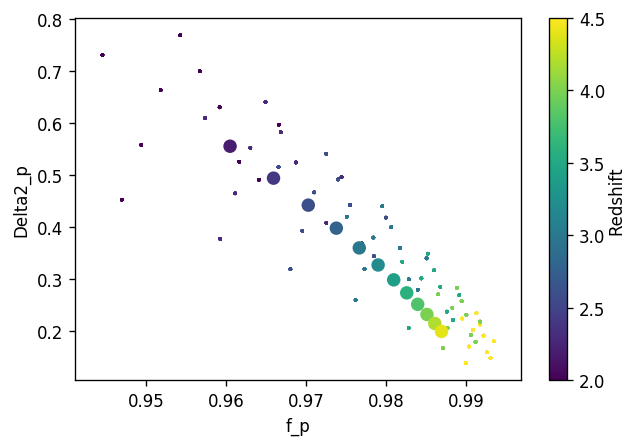

In [11]:
overplot_parameter_pair(arxiv,emu_calls,'f_p','Delta2_p',zs)

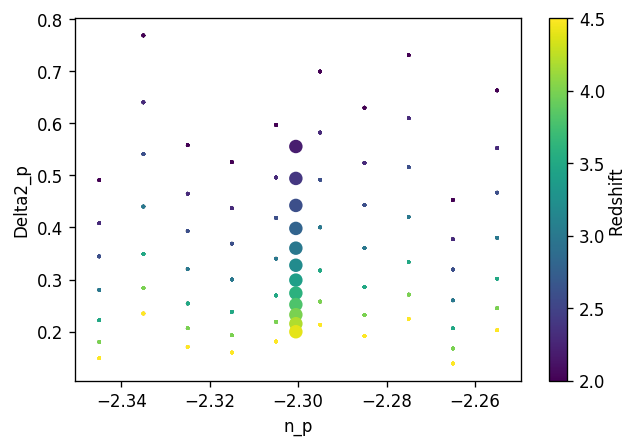

In [12]:
overplot_parameter_pair(arxiv,emu_calls,'n_p','Delta2_p',zs)

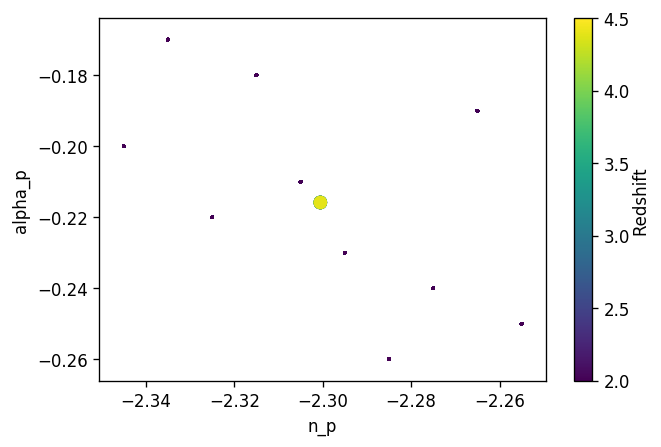

In [13]:
overplot_parameter_pair(arxiv,emu_calls,'n_p','alpha_p',zs)

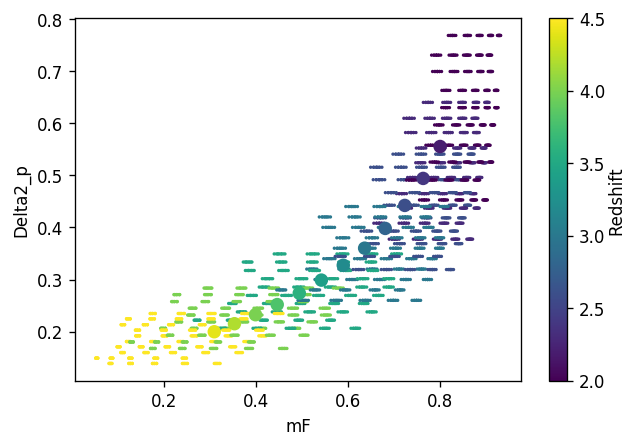

In [14]:
overplot_parameter_pair(arxiv,emu_calls,'mF','Delta2_p',zs=zs,drop_rescaled_tau=False)

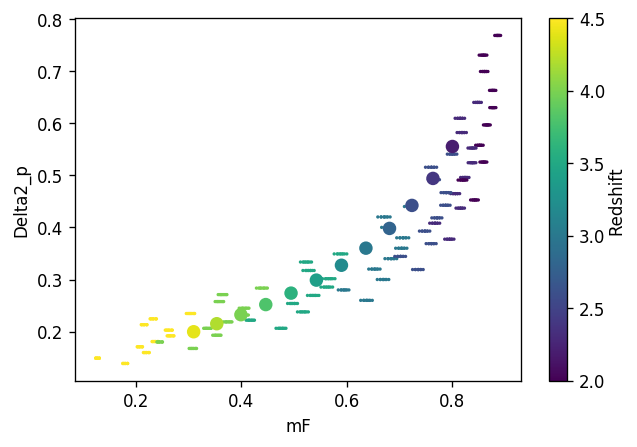

In [15]:
overplot_parameter_pair(arxiv,emu_calls,'mF','Delta2_p',zs=zs,drop_rescaled_tau=True)

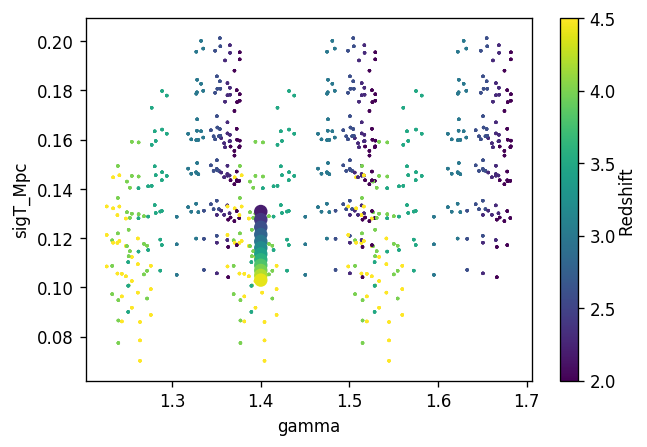

In [16]:
overplot_parameter_pair(arxiv,emu_calls,'gamma','sigT_Mpc',zs,drop_rescaled_temp=False)

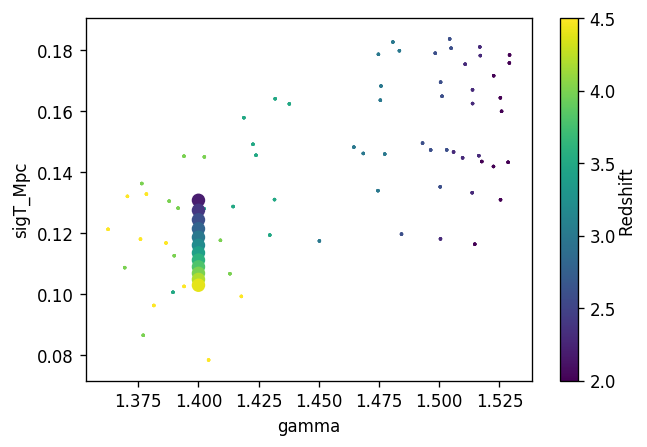

In [17]:
overplot_parameter_pair(arxiv,emu_calls,'gamma','sigT_Mpc',zs,drop_rescaled_temp=True)